# data analysis and wrangling


## Imports

In [679]:
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import ppscore as pps

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier


## Load Data

In [680]:
train_df = pd.read_csv('../dataset/train.csv')
test_df = pd.read_csv('../dataset/test.csv')
combine = [train_df , test_df]
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [681]:
for dataset in combine:
    dataset['Mu'] = 1
    dataset.loc[(dataset.Ticket.duplicated(keep= False)) , 'Mu'] = 0
    dataset['Mu'] = dataset['Mu'].astype(int)
train_df[['Mu', 'Survived']].groupby(['Mu'], as_index=False).mean()
pd.crosstab(train_df['Mu'], train_df['Survived'])

Survived,0,1
Mu,,
0,165,179
1,384,163


In [682]:
cabin_category = {'A':9, 'B':8, 'C':7, 'D':6, 'E':5, 'F':4, 'G':3, 'T':2, 'U':1}
for dataset in combine:
    dataset['Cabin'] = dataset['Cabin'].fillna('U')
    dataset['Cabin'] = dataset['Cabin'].replace('([0-9]+)', '',regex=True).str.slice(0, 1)
    dataset['Cabin'] = dataset['Cabin'].map(cabin_category)
train_df[["Cabin", "Survived"]].groupby(['Cabin'], as_index=False).mean().sort_values(by='Survived', ascending=False)
pd.crosstab(train_df['Cabin'], train_df['Survived'])

Survived,0,1
Cabin,,
1,481,206
2,1,0
3,2,2
4,5,8
5,8,24
6,8,25
7,24,35
8,12,35
9,8,7


In [683]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

train_df = train_df.drop([ 'Ticket'], axis=1)
test_df = test_df.drop([  'Ticket'], axis=1)
combine = [train_df, test_df]

"After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape

Before (891, 13) (418, 12) (891, 13) (418, 12)


('After', (891, 12), (418, 11), (891, 12), (418, 11))

In [684]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    
pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [685]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Mlle', 'Lady', 'Ms', 'Countess'], 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset['Title'] = dataset['Title'].replace(['Sir', 'Major'], 'Mr')
    dataset['Title'] = dataset['Title'].replace('^(?!.*(Miss|Mrs|Mr|Master)).*$', 'Rare',regex=True)
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.705882
2,Mr,0.159615
3,Mrs,0.793651
4,Rare,0.222222


In [686]:
title_mapping = {"Mr": 1, "Miss": 4, "Mrs": 2, "Master": 3, "Rare": 0}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Mu,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,1,S,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,7,C,1,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,1,S,1,4
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,7,S,0,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,1,S,1,1


In [687]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 11), (418, 11))

In [688]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Mu,Title
0,0,3,0,22.0,1,0,7.2500,1,S,1,1
1,1,1,1,38.0,1,0,71.2833,7,C,1,2
2,1,3,1,26.0,0,0,7.9250,1,S,1,4
3,1,1,1,35.0,1,0,53.1000,7,S,0,2
4,0,3,0,35.0,0,0,8.0500,1,S,1,1


## Completing a numerical continuous feature¶


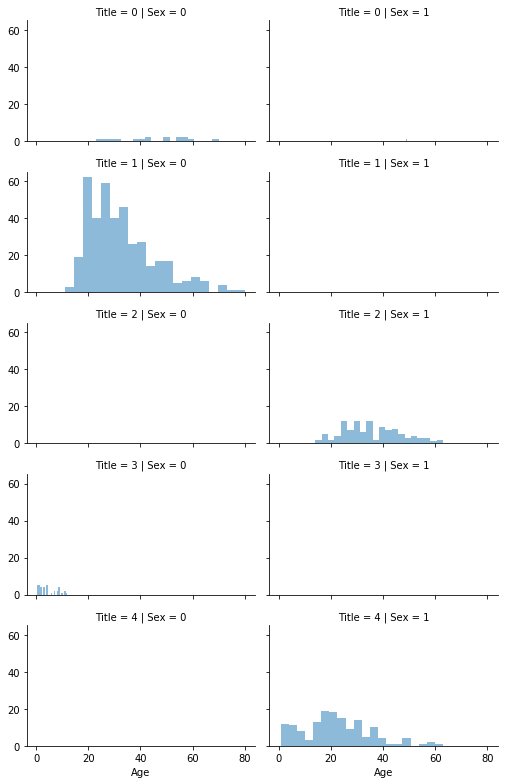

In [689]:
grid = sns.FacetGrid(train_df, row='Title', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

In [690]:
guess_ages = np.zeros((2,5))
guess_ages

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [691]:
for dataset in combine:
    for i in range(0,2):
        for j in range(0,5):
            guss_df = dataset[(dataset['Sex'] == i) & (dataset['Title'] == j +1)]['Age'].dropna()
            guss_age = guss_df.median()
            if guss_age != guss_age:
                guss_age = -5 #dataset[(dataset['Sex'] == i)]['Age'].dropna().median()
            guess_ages[i,j] = int(guss_age/0.5 + 0.5) * 0.5
    for i in range(0,2):
        for j in range(0,5):
            dataset.loc[(dataset.Age.isnull()) & (dataset.Sex == i ) & ( dataset.Title == j+1), 'Age'] = guess_ages[i,j]
    
    dataset.loc[(dataset.Age.isnull()), 'Age'] = dataset[(dataset['Sex'] == i)]['Age'].dropna().median()           
    dataset['Age'] = dataset['Age'].astype(int)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Mu,Title
0,0,3,0,22,1,0,7.2500,1,S,1,1
1,1,1,1,38,1,0,71.2833,7,C,1,2
2,1,3,1,26,0,0,7.9250,1,S,1,4
3,1,1,1,35,1,0,53.1000,7,S,0,2
4,0,3,0,35,0,0,8.0500,1,S,1,1


In [692]:
# train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
# train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

In [693]:
# for dataset in combine:    
#     dataset.loc[ dataset['Age'] <= 16, 'Age'] = 4
#     dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 3
#     dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
#     dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 1
#     dataset.loc[ dataset['Age'] > 64, 'Age'] = 0
# train_df.head()

In [694]:
# train_df = train_df.drop(['AgeBand'], axis=1)
# combine = [train_df, test_df]
# train_df.head()

In [695]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [696]:
# for dataset in combine:
#     dataset['IsAlone'] = 0
#     dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

# train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

In [697]:
train_df = train_df.drop(['Parch', 'SibSp'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp'], axis=1)
combine = [train_df, test_df]

train_df.head()

# train_df = train_df.drop([ 'FamilySize'], axis=1)
# test_df = test_df.drop([ 'FamilySize'], axis=1)
# combine = [train_df, test_df]

# train_df.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Mu,Title,FamilySize
0,0,3,0,22,7.2500,1,S,1,1,2
1,1,1,1,38,71.2833,7,C,1,2,2
2,1,3,1,26,7.9250,1,S,1,4,1
3,1,1,1,35,53.1000,7,S,0,2,2
4,0,3,0,35,8.0500,1,S,1,1,1


In [698]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,66,22,3
1,38,38,1
2,78,26,3
3,35,35,1
4,105,35,3
5,90,30,3
6,54,54,1
7,6,2,3
8,81,27,3
9,28,14,2


In [699]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [700]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [701]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 2, 'Q': 1} ).astype(int)

train_df.head()

# train_df = train_df.drop(['Embarked'], axis=1)
# test_df = test_df.drop(['Embarked'], axis=1)
# combine = [train_df, test_df]

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Mu,Title,FamilySize,Age*Class
0,0,3,0,22,7.2500,1,0,1,1,2,66
1,1,1,1,38,71.2833,7,2,1,2,2,38
2,1,3,1,26,7.9250,1,0,1,4,1,78
3,1,1,1,35,53.1000,7,0,0,2,2,35
4,0,3,0,35,8.0500,1,0,1,1,1,105


In [702]:
for dataset in combine:
    dataset['Pclass'] = dataset['Pclass'].fillna(freq_port)
    
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [703]:
for dataset in combine:
    dataset['Pclass'] = dataset['Pclass'].map( {3: 0, 2: 1, 1: 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Mu,Title,FamilySize,Age*Class
0,0,0,0,22,7.2500,1,0,1,1,2,66
1,1,2,1,38,71.2833,7,2,1,2,2,38
2,1,0,1,26,7.9250,1,0,1,4,1,78
3,1,2,1,35,53.1000,7,0,0,2,2,35
4,0,0,0,35,8.0500,1,0,1,1,1,105


In [704]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Cabin,Embarked,Mu,Title,FamilySize,Age*Class
0,892,0,0,34,7.8292,1,1,1,1,1,102
1,893,0,1,47,7.0000,1,0,1,2,2,141
2,894,1,0,62,9.6875,1,1,1,1,1,124
3,895,0,0,27,8.6625,1,0,1,1,1,81
4,896,0,1,22,12.2875,1,0,1,2,3,66


In [705]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [706]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Mu,Title,FamilySize,Age*Class
0,0,0,0,22,0,1,0,1,1,2,66
1,1,2,1,38,3,7,2,1,2,2,38
2,1,0,1,26,1,1,0,1,4,1,78
3,1,2,1,35,3,7,0,0,2,2,35
4,0,0,0,35,1,1,0,1,1,1,105
5,0,0,0,30,1,1,1,1,1,1,90
6,0,2,0,54,3,5,0,1,1,1,54
7,0,0,0,2,2,1,0,0,3,5,6
8,1,0,1,27,1,1,0,0,2,3,81
9,1,1,1,14,2,1,2,0,2,2,28


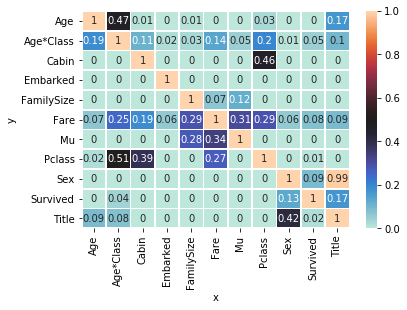

In [707]:
matrix_pps = pps.matrix(train_df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
matrix_pps = matrix_pps.apply(lambda x: round(x, 2))

sns.heatmap(matrix_pps, vmin=0, vmax=1, cmap="icefire", linewidths=0.75, annot=True)

In [708]:
# dummy_col=['Title', 'Age', 'FamilySize', 'Cabin', 'Embarked', 'Pclass', 'Fare']


# df = pd.concat((train_df.loc[:,'Pclass':'IsAlone'], test_df.loc[:,'Pclass':'IsAlone'])).reset_index(drop=True)
# dummy = pd.get_dummies(df[dummy_col], columns=dummy_col, drop_first=False)
# df = pd.concat([dummy, df], axis = 1)



# df = df.drop(dummy_col, axis=1)

# # train_df = df[:train_df.shape[0]]
# # test_df = df[train_df.shape[0]:]   
   

# X_train = df[:train_df.shape[0]]
# Y_train = train_df["Survived"]
# X_test  =  df[train_df.shape[0]:]   
# X_train.shape, Y_train.shape, X_test.shape


## Model, predict and solve


In [709]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape


((891, 10), (891,), (418, 10))

In [710]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
Y_pred.astype(int)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

80.13

In [711]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.275528
0,Pclass,0.669447
7,Title,0.191278
3,Fare,0.178328
5,Embarked,0.166643
4,Cabin,0.081280
9,Age*Class,-0.003981
2,Age,-0.027838
8,FamilySize,-0.369949
6,Mu,-0.401410


In [712]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
Y_pred = Y_pred.astype(int)

acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

70.93

In [713]:
knn = KNeighborsClassifier(n_neighbors = 35)
knn.fit(X_train, Y_train)

acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
Y_pred = knn.predict(X_test)
Y_pred = Y_pred.astype(int)
acc_knn

72.28

In [714]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

77.67

In [715]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

74.52

In [716]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

78.9

In [717]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

77.22

In [725]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

96.3

In [719]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
Y_pred = Y_pred.astype(int)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

96.3

In [720]:
MLP = MLPClassifier(random_state=1, max_iter=300 )
MLP.fit(X_train, Y_train)
Y_pred = MLP.predict(X_test)
Y_pred = Y_pred.astype(int)
MLP.score(X_train, Y_train)
acc_MLP = round(MLP.score(X_train, Y_train) * 100, 2)
acc_MLP

84.06

In [726]:
    models = pd.DataFrame({'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'MLP'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree, acc_MLP]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,96.30
8,Decision Tree,96.30
9,MLP,84.06
2,Logistic Regression,80.13
7,Linear SVC,78.90
4,Naive Bayes,77.67
6,Stochastic Gradient Decent,77.22
5,Perceptron,74.52
1,KNN,72.28
0,Support Vector Machines,70.93


In [727]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('../out/submission.csv', index=False)

In [723]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

model = tf.keras.Sequential([
    tf.keras.layers.Dense(82, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(2)
])
X_train = X_train.astype(float)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(X_train.values, Y_train.values, epochs=25)              

Train on 891 samples
Epoch 1/25
891/891 [==============================] - 1s 678us/sample - loss: 1.2219 - accuracy: 0.6308
Epoch 2/25
891/891 [==============================] - 0s 219us/sample - loss: 0.5856 - accuracy: 0.7127
Epoch 3/25
891/891 [==============================] - 0s 238us/sample - loss: 0.6245 - accuracy: 0.7026
Epoch 4/25
891/891 [==============================] - 0s 261us/sample - loss: 0.5497 - accuracy: 0.7497
Epoch 5/25
891/891 [==============================] - 0s 250us/sample - loss: 0.5507 - accuracy: 0.7430
Epoch 6/25
891/891 [==============================] - 0s 251us/sample - loss: 0.5267 - accuracy: 0.7576
Epoch 7/25
891/891 [==============================] - 0s 218us/sample - loss: 0.5018 - accuracy: 0.7710
Epoch 8/25
891/891 [==============================] - 0s 269us/sample - loss: 0.4990 - accuracy: 0.7609
Epoch 9/25
891/891 [==============================] - 0s 277us/sample - loss: 0.4669 - accuracy: 0.7924
Epoch 10/25
891/891 [======================

In [724]:
Y_pred_r = model.predict(X_test)
Y_pred = np.zeros(len(Y_pred_r))
for  index, x in enumerate(Y_pred_r):
    if x[0] < x[1]:
        Y_pred[index] = 1
Y_pred = Y_pred.astype(int)
Y_pred        


array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,